<img src=https://www.udc.es/export/sites/udc/silazarillo/_galeria_imgs/03_Simbolo_logo_cor.png_2063069294.png width="300" align="left">
<br />

# PAN: Homework \#2 - Membership inference
#### <font color=green>*Máster Inter-Universitario en Ciberseguridad*</font>

Author: Daniel Feito Pin

## Statement

In this homework, you should implement a membership inference attack on two different models, a Multi-Layer Perceptron (MLP) and a Convolutional Neural Network (CNN) both trained on the CIFAR10 image dataset we already used in Labwork 8.

As a reminder, such a dataset consists of 60,000 real photographs divided into 10 classes. The classes include common objects such as airplanes, automobiles, birds, cats, etc. The dataset is already divided into a training set of 50,000 images and a test set consisting of the remaining 10,000 images. The images contain 3 channels (red, green and blue) and have a resolution of 32 x 32 pixels.

In the next sections, you are provided with a skeleton of the steps you must follow to perform the attack

## Load data

Firstly, you must load the dataset. Take into account that the prebuilt data division (training and testing) should be adjusted in order to use approximately 30,000 images (50%) for training/testing and the rest to build the shadow models. The train/test split should be 75% and 25%, respectively.

In [2]:
import numpy as np
from numpy import ndarray
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

# Load data
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Join data
joined_images: ndarray = np.concatenate((train_images, test_images), axis=0)/255.0
joined_labels: ndarray = np.concatenate((train_labels, test_labels), axis=0)
del(train_images)
del(train_labels)
del(test_images)
del(test_labels)

n_classes: int = len(np.unique(joined_labels))

# Split data (50% for training/test and 50% for shadow models)
train_test_images, shadow_model_images = np.split(joined_images, 2)
train_test_labels, shadow_model_labels = np.split(joined_labels, 2)
del(joined_images)
del(joined_labels)

# Train and test data split
X_train, X_test, y_train, y_test = train_test_split(train_test_images, train_test_labels, train_size=0.75)
del(train_test_images)
del(train_test_labels)

In [3]:
print(f'Training sample: {len(X_train)}\nTest sample: {len(X_test)}\nShadow sample: {len(shadow_model_images)}')

Training sample: 22500
Test sample: 7500
Shadow sample: 30000


## Train models

Now, you should build and train both MLP and CNN models... You can adapt the models used in previous labs!

**Warning!:** it may take some time to train the models, so we encourage you to save them to a file, so that you do not have to wait for the training to complete every time you want to run this lab.

In addition, **you will be required to upload the training model used to perform the attack**, so that we can reproduce the experiment!

In [4]:
# You should disable Tensorflow eager execution, otherwise ART attack won't work!!!
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
tf.compat.v1.disable_eager_execution()

### MLP

In [5]:
def nn_model(n_inputs, n_outputs, metrics):
    
    model = models.Sequential()

    model.add(layers.Dense(3000, input_dim=n_inputs, activation='relu'))
    model.add(layers.Dense(1000, activation='relu'))
    model.add(layers.Dense(400, activation='relu'))
    model.add(layers.Dense(n_outputs, activation='softmax'))
    
    opt = keras.optimizers.legacy.Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=metrics)
    
    return model

In [6]:
n_inputs: int = np.prod(X_train.shape[1:])
n_outputs: int = n_classes
metrics: list[str] = ['accuracy','AUC','Recall','Precision']
mlp_model = nn_model(n_inputs, n_outputs, metrics)
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3000)              9219000   
                                                                 
 dense_1 (Dense)             (None, 1000)              3001000   
                                                                 
 dense_2 (Dense)             (None, 400)               400400    
                                                                 
 dense_3 (Dense)             (None, 10)                4010      
                                                                 
Total params: 12624410 (48.16 MB)
Trainable params: 12624410 (48.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
# Training...
X_train_reshaped: ndarray = X_train.reshape(-1, np.prod(X_train.shape[1:]))
X_test_reshaped: ndarray = X_test.reshape(-1, np.prod(X_test.shape[1:]))
y_train_cat: ndarray = to_categorical(y_train, num_classes=n_classes)
y_test_cat: ndarray = to_categorical(y_test, num_classes=n_classes)

history = mlp_model.fit(X_train_reshaped, y_train_cat, validation_data=(X_test_reshaped, y_test_cat), epochs=30, batch_size=40)



Train on 22500 samples, validate on 7500 samples
Epoch 1/30
22500/22500 [==============================] - ETA: 0s - loss: 2.0359 - accuracy: 0.2754 - AUC: 0.7428 - Recall: 0.0408 - Precision: 0.4978

c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


22500/22500 [==============================] - 45s 2ms/sample - loss: 2.0359 - accuracy: 0.2754 - AUC: 0.7428 - Recall: 0.0408 - Precision: 0.4978 - val_loss: 1.7904 - val_accuracy: 0.3479 - val_AUC: 0.8046 - val_Recall: 0.0687 - val_Precision: 0.6342
Epoch 2/30
22500/22500 [==============================] - 55s 2ms/sample - loss: 1.7863 - accuracy: 0.3503 - AUC: 0.8056 - Recall: 0.1039 - Precision: 0.5919 - val_loss: 1.7582 - val_accuracy: 0.3719 - val_AUC: 0.8114 - val_Recall: 0.1337 - val_Precision: 0.6071
Epoch 3/30
22500/22500 [==============================] - 55s 2ms/sample - loss: 1.7037 - accuracy: 0.3885 - AUC: 0.8263 - Recall: 0.1347 - Precision: 0.6021 - val_loss: 1.6442 - val_accuracy: 0.4064 - val_AUC: 0.8398 - val_Recall: 0.1437 - val_Precision: 0.6646
Epoch 4/30
22500/22500 [==============================] - 49s 2ms/sample - loss: 1.6399 - accuracy: 0.4105 - AUC: 0.8407 - Recall: 0.1688 - Precision: 0.6278 - val_loss: 1.6363 - val_accuracy: 0.4111 - val_AUC: 0.8423 - va

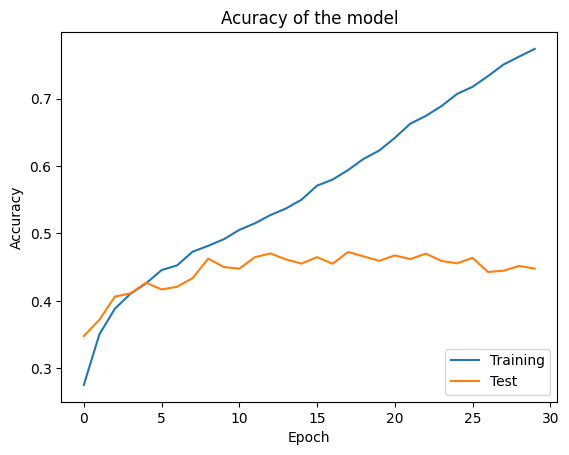

In [8]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acuracy of the model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Test'], loc='lower right')
plt.show()

In [9]:
# Save weights
PATH_TO_WEIGHTS = './homework_checkpoints/mlp.h5'
mlp_model.save_weights(PATH_TO_WEIGHTS)

In [10]:
# Load weights
mlp_model.load_weights(PATH_TO_WEIGHTS)

### CNN

In [11]:
def cnn(metrics):
    model = models.Sequential()
    
    model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(10))
    
    opt = keras.optimizers.legacy.Adam(learning_rate=0.001) 
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=opt, metrics=metrics)
    
    return model

In [12]:
cnn_model = cnn(['accuracy'])
cnn_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                     

In [13]:
# Training...
history = cnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=40)

Train on 22500 samples, validate on 7500 samples
Epoch 1/30
22480/22500 [============================>.] - ETA: 0s - loss: 1.8561 - accuracy: 0.3102

c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


22500/22500 [==============================] - 36s 2ms/sample - loss: 1.8557 - accuracy: 0.3103 - val_loss: 1.5270 - val_accuracy: 0.4393
Epoch 2/30
22500/22500 [==============================] - 36s 2ms/sample - loss: 1.4281 - accuracy: 0.4753 - val_loss: 1.2260 - val_accuracy: 0.5472
Epoch 3/30
22500/22500 [==============================] - 36s 2ms/sample - loss: 1.2415 - accuracy: 0.5514 - val_loss: 1.1382 - val_accuracy: 0.5837
Epoch 4/30
22500/22500 [==============================] - 36s 2ms/sample - loss: 1.0879 - accuracy: 0.6128 - val_loss: 1.0320 - val_accuracy: 0.6323
Epoch 5/30
22500/22500 [==============================] - 37s 2ms/sample - loss: 0.9815 - accuracy: 0.6532 - val_loss: 0.9447 - val_accuracy: 0.6643
Epoch 6/30
22500/22500 [==============================] - 36s 2ms/sample - loss: 0.8985 - accuracy: 0.6824 - val_loss: 0.9038 - val_accuracy: 0.6827
Epoch 7/30
22500/22500 [==============================] - 36s 2ms/sample - loss: 0.8231 - accuracy: 0.7104 - val_loss

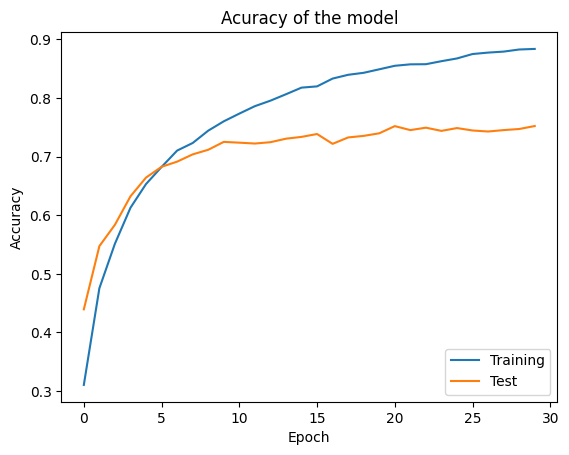

In [14]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acuracy of the model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Test'], loc='lower right')
plt.show()

In [15]:
# Save weights... Update your path!!
cnn_model.save_weights('./homework_checkpoints/cnn.h5')

In [16]:
# Load weights... Update your path!!
cnn_model.load_weights('./homework_checkpoints/cnn.h5')

## Train shadow models

You should train three shadow models for each one of your classifiers (MLP and CNN), using a shadow dataset based on the data you have previously isolated for this purpose.

Compute the accuracy obtained for such models!

### MLP

In [17]:
from art.attacks.inference.membership_inference import ShadowModels
from art.estimators.classification.keras import KerasClassifier

mlp_art_classifier = KerasClassifier(mlp_model)

mlp_shadow_models = ShadowModels(mlp_art_classifier, num_shadow_models=3)

shadow_model_images_reshaped: ndarray = shadow_model_images.reshape(
    -1, np.prod(shadow_model_images.shape[1:]))
shadow_model_labels_cat: ndarray = to_categorical(
    shadow_model_labels, num_classes=n_classes)

mlp_shadow_dataset = mlp_shadow_models.generate_shadow_dataset(
    shadow_model_images_reshaped, shadow_model_labels_cat)
(mlp_member_x, mlp_member_y, mlp_member_predictions), (mlp_nonmember_x,
                                                       mlp_nonmember_y, mlp_nonmember_predictions) = mlp_shadow_dataset

Train on 15000 samples
Epoch 1/20
15000/15000 [==============================] - 9s 582us/sample - loss: 3.7339 - accuracy: 0.2089 - AUC: 0.6672 - Recall: 0.0199 - Precision: 0.2037
Epoch 2/20
15000/15000 [==============================] - 8s 562us/sample - loss: 1.8874 - accuracy: 0.3167 - AUC: 0.7753 - Recall: 0.0499 - Precision: 0.5741
Epoch 3/20
15000/15000 [==============================] - 8s 555us/sample - loss: 1.7964 - accuracy: 0.3526 - AUC: 0.8018 - Recall: 0.0946 - Precision: 0.6003
Epoch 4/20
15000/15000 [==============================] - 8s 563us/sample - loss: 1.7363 - accuracy: 0.3729 - AUC: 0.8173 - Recall: 0.1249 - Precision: 0.6129
Epoch 5/20
15000/15000 [==============================] - 9s 570us/sample - loss: 1.6921 - accuracy: 0.3911 - AUC: 0.8285 - Recall: 0.1431 - Precision: 0.6365
Epoch 6/20
15000/15000 [==============================] - 9s 628us/sample - loss: 1.6548 - accuracy: 0.4059 - AUC: 0.8370 - Recall: 0.1655 - Precision: 0.6374
Epoch 7/20
15000/15000 

c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 15000 samples
Epoch 1/20
15000/15000 [==============================] - 9s 619us/sample - loss: 4.4652 - accuracy: 0.2257 - AUC: 0.6791 - Recall: 0.0256 - Precision: 0.2305
Epoch 2/20
15000/15000 [==============================] - 9s 608us/sample - loss: 1.8474 - accuracy: 0.3293 - AUC: 0.7879 - Recall: 0.0761 - Precision: 0.5777
Epoch 3/20
15000/15000 [==============================] - 9s 615us/sample - loss: 1.7526 - accuracy: 0.3693 - AUC: 0.8138 - Recall: 0.1077 - Precision: 0.6031
Epoch 4/20
15000/15000 [==============================] - 9s 603us/sample - loss: 1.7169 - accuracy: 0.3817 - AUC: 0.8228 - Recall: 0.1262 - Precision: 0.6128
Epoch 5/20
15000/15000 [==============================] - 10s 653us/sample - loss: 1.6824 - accuracy: 0.3980 - AUC: 0.8307 - Recall: 0.1433 - Precision: 0.6293
Epoch 6/20
15000/15000 [==============================] - 9s 628us/sample - loss: 1.6471 - accuracy: 0.4073 - AUC: 0.8386 - Recall: 0.1577 - Precision: 0.6418
Epoch 7/20
15000/15000

In [18]:
# Shadow models' accuracy
loss_and_metrics = [sm.model.evaluate(X_test_reshaped, y_test_cat) for sm in mlp_shadow_models.get_shadow_models()]
print([e[1] for e in loss_and_metrics]) # Accuracy at index 1

c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


[0.4204, 0.4396, 0.4376]


### CNN

In [19]:
from art.attacks.inference.membership_inference import ShadowModels
from art.estimators.classification.keras import KerasClassifier

cnn_art_classifier = KerasClassifier(cnn_model)

cnn_shadow_models = ShadowModels(cnn_art_classifier, num_shadow_models=3)

cnn_shadow_dataset = cnn_shadow_models.generate_shadow_dataset(
    shadow_model_images, shadow_model_labels)
(cnn_member_x, cnn_member_y, cnn_member_predictions), (cnn_nonmember_x,
                                                       cnn_nonmember_y, cnn_nonmember_predictions) = cnn_shadow_dataset

Train on 15000 samples
Epoch 1/20
15000/15000 [==============================] - 31s 2ms/sample - loss: 2.3471 - accuracy: 0.0985
Epoch 2/20
15000/15000 [==============================] - 30s 2ms/sample - loss: 2.3027 - accuracy: 0.1039
Epoch 3/20
15000/15000 [==============================] - 32s 2ms/sample - loss: 2.3025 - accuracy: 0.1039
Epoch 4/20
15000/15000 [==============================] - 29s 2ms/sample - loss: 2.3026 - accuracy: 0.1008
Epoch 5/20
15000/15000 [==============================] - 20s 1ms/sample - loss: 2.3025 - accuracy: 0.1039
Epoch 6/20
15000/15000 [==============================] - 20s 1ms/sample - loss: 2.3025 - accuracy: 0.1039
Epoch 7/20
15000/15000 [==============================] - 20s 1ms/sample - loss: 2.3025 - accuracy: 0.1039
Epoch 8/20
15000/15000 [==============================] - 20s 1ms/sample - loss: 2.3025 - accuracy: 0.1039
Epoch 9/20
15000/15000 [==============================] - 20s 1ms/sample - loss: 2.3025 - accuracy: 0.1039
Epoch 10/20
15

In [21]:
# Shadow models' accuracy
loss_and_metrics = [sm.model.evaluate(X_test, y_test) for sm in cnn_shadow_models.get_shadow_models()]
print([e[1] for e in loss_and_metrics]) # Accuracy at index 1

[0.097333334, 0.6036, 0.6432]


## Perform the black-box attack

Using the attack models you have built on the previous step, perform the inference attack over the training and testing data to guess whether they belong to the training set or not.

Assess the performance for both training samples (members) and non-training samples (non-members)

In [22]:
from art.attacks.inference.membership_inference import MembershipInferenceBlackBox

In [23]:
def calc_precision_recall(predicted, actual, positive_value=1):
    score = 0  # both predicted and actual are positive
    num_positive_predicted = 0  # predicted positive
    num_positive_actual = 0  # actual positive
    for i in range(len(predicted)):
        if predicted[i] == positive_value:
            num_positive_predicted += 1
        if actual[i] == positive_value:
            num_positive_actual += 1
        if predicted[i] == actual[i]:
            if predicted[i] == positive_value:
                score += 1
    
    if num_positive_predicted == 0:
        precision = 1
    else:
        precision = score / num_positive_predicted  # the fraction of predicted “Yes” responses that are correct
    if num_positive_actual == 0:
        recall = 1
    else:
        recall = score / num_positive_actual  # the fraction of “Yes” responses that are predicted correctly

    return precision, recall

### MLP

In [24]:
mlp_attack = MembershipInferenceBlackBox(mlp_art_classifier, attack_model_type="rf")
mlp_attack.fit(mlp_member_x, mlp_member_y, mlp_nonmember_x, mlp_nonmember_y, mlp_member_predictions, mlp_nonmember_predictions)

In [25]:
mlp_member_infer = mlp_attack.infer(X_train_reshaped, y_train_cat)
mlp_nonmember_infer = mlp_attack.infer(X_test_reshaped, y_test_cat)
mlp_member_acc = np.sum(mlp_member_infer) / len(X_train_reshaped)
mlp_nonmember_acc = 1 - np.sum(mlp_nonmember_infer) / len(X_test_reshaped)
mlp_acc = (mlp_member_acc * len(X_train_reshaped) + mlp_nonmember_acc * len(X_test_reshaped)) / (len(X_train_reshaped) + len(X_test_reshaped))
print('Attack Member Acc:', mlp_member_acc)
print('Attack Non-Member Acc:', mlp_nonmember_acc)
print('Attack Accuracy:', mlp_acc)

c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Attack Member Acc: 0.6548
Attack Non-Member Acc: 0.5262666666666667
Attack Accuracy: 0.6226666666666667


In [26]:
print(calc_precision_recall(np.concatenate((mlp_member_infer, mlp_nonmember_infer)), 
                            np.concatenate((np.ones(len(mlp_member_infer)), np.zeros(len(mlp_nonmember_infer))))))

(0.8056983484633052, 0.6548)


### CNN

In [27]:
cnn_attack = MembershipInferenceBlackBox(cnn_art_classifier, attack_model_type="rf")
cnn_attack.fit(cnn_member_x, cnn_member_y, cnn_nonmember_x, cnn_nonmember_y, cnn_member_predictions, cnn_nonmember_predictions)

In [29]:
cnn_member_infer = cnn_attack.infer(X_train, y_train)
cnn_nonmember_infer = cnn_attack.infer(X_test, y_test)
cnn_member_acc = np.sum(cnn_member_infer) / len(X_train)
cnn_nonmember_acc = 1 - np.sum(cnn_nonmember_infer) / len(X_test)
cnn_acc = (cnn_member_acc * len(X_train) + cnn_nonmember_acc * len(X_test)) / (len(X_train) + len(X_test))
print('Attack Member Acc:', cnn_member_acc)
print('Attack Non-Member Acc:', cnn_nonmember_acc)
print('Attack Accuracy:', cnn_acc)

c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Attack Member Acc: 0.5958222222222223
Attack Non-Member Acc: 0.4524
Attack Accuracy: 0.5599666666666666


In [30]:
print(calc_precision_recall(np.concatenate((cnn_member_infer, cnn_nonmember_infer)), 
                            np.concatenate((np.ones(len(cnn_member_infer)), np.zeros(len(cnn_nonmember_infer))))))

(0.7654884942614059, 0.5958222222222223)


## Results

### Data

The data set used for this lab was the **CIFAR10** image dataset. this dataset consists of **60,000** real photographs divided into **10 classes**.

The class used to import the data already gives a partition of the data, so first I reunited the data in a unique dataframe to make my own partition. 

Once all the images were grouped in the same dataframe, I splitted this in half, making one group for train and test and the other for the shadow models. The first group was then splitted again to use the 75% to train and the 25% to test.

|Partitions|Samples|
|:--:|:--:|
|Training sample| 22500|
|Test sample| 7500|
|Shadow sample| 30000|

### MLP attack

|Metric| Value|
|:----:|:--|
|Attack Member Acc | 0.6548 |
|Attack Non-Member Acc| 0.5262666666666667|
|Attack Accuracy| 0.6226666666666667|

### CNN attack
|Metric|Value|
|:----:|:--|
|Attack Member Acc | 0.5958222222222223 |
|Attack Non-Member Acc| 0.4524|
|Attack Accuracy| 0.5599666666666666|

### Discussion

- It is shown that the MLP attack obtained better results than the CNN attack.
- In both cases the attack on member samples obtained better results.
- The MLP graph indicates that the model is learning adequately, but is not as good at generalizing new data, since the test curve does not exceed 45%.
- The CNN graph, for its part, shows that the model scales appropriately and is also able to classify new data successfully.